In [1]:
import pandas as pd
import numpy as np 
import altair as alt
import matplotlib.pyplot as plt
import panel as pn
import datetime
from numpy import array
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from google.colab import drive

In [2]:
alt.renderers.enable('default')
pn.extension('vega')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [28]:
nigeria_covid_cases

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
58890,2020-01-03,NG,Nigeria,AFRO,0.0,0.0,0.0,0.0
58891,2020-01-04,NG,Nigeria,AFRO,0.0,0.0,0.0,0.0
58892,2020-01-05,NG,Nigeria,AFRO,0.0,0.0,0.0,0.0
58893,2020-01-06,NG,Nigeria,AFRO,0.0,0.0,0.0,0.0
58894,2020-01-07,NG,Nigeria,AFRO,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
59275,2021-01-22,NG,Nigeria,AFRO,1962.0,116653.0,7.0,1485.0
59276,2021-01-23,NG,Nigeria,AFRO,1485.0,118138.0,5.0,1490.0
59277,2021-01-24,NG,Nigeria,AFRO,2464.0,120602.0,5.0,1495.0
59278,2021-01-25,NG,Nigeria,AFRO,964.0,121566.0,2.0,1497.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Reads the excel file and filter on Nigeria Cases
nigeria_covid_cases = pd.read_excel('/content/drive/MyDrive/WHO-COVID-19-global-data.xlsx')
mask = nigeria_covid_cases['Country'] == 'Nigeria'
nigeria_covid_cases = nigeria_covid_cases.loc[mask]

In [5]:
nigeria_covid_cases['Date_reported'] = pd.to_datetime(nigeria_covid_cases['Date_reported'])


Text(0.5, 0, 'Date')

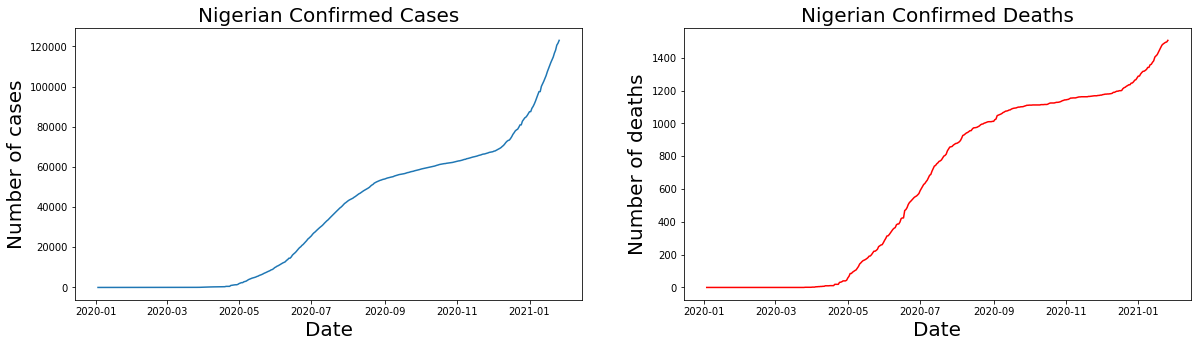

In [6]:
temp_nigeria_covid_cases = nigeria_covid_cases.copy()
temp_nigeria_covid_cases.index = temp_nigeria_covid_cases['Date_reported']
cum_cases = temp_nigeria_covid_cases[['Cumulative_cases']]
cum_death = temp_nigeria_covid_cases[['Cumulative_deaths']]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.plot(cum_cases)
ax1.set_title("Nigerian Confirmed Cases", size=20)
ax1.set_ylabel("Number of cases", size=20)
ax1.set_xlabel("Date", size=20)

ax2.plot(cum_death, color="red")
ax2.set_title("Nigerian Confirmed Deaths", size=20)
ax2.set_ylabel("Number of deaths", size=20)
ax2.set_xlabel("Date", size=20)

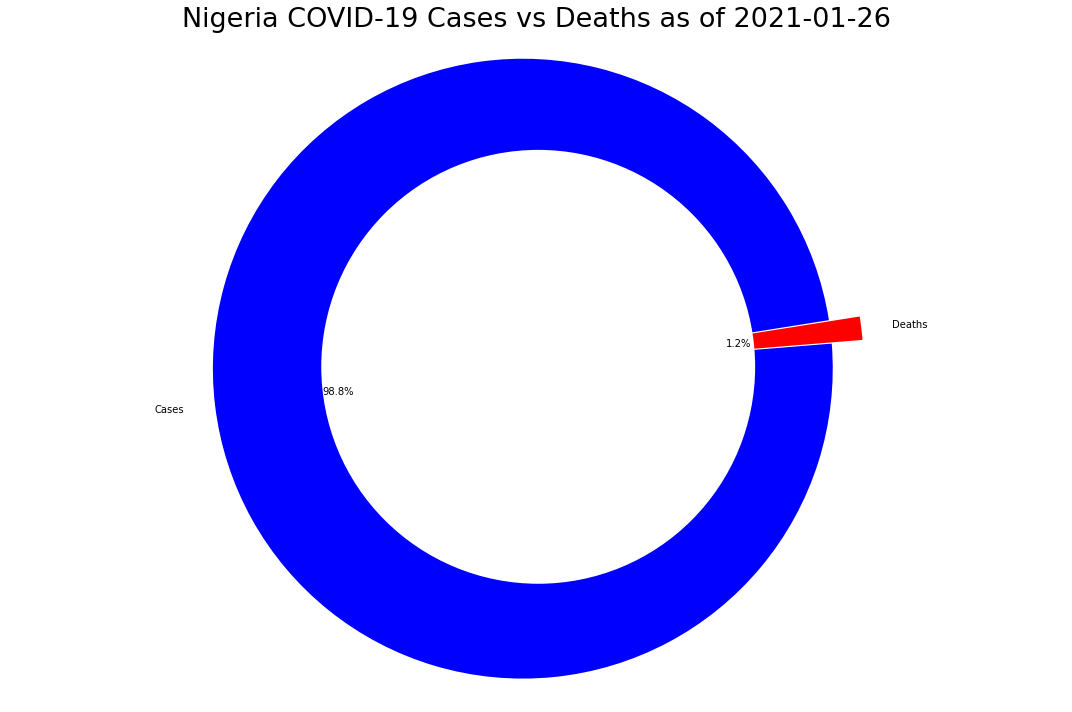

In [7]:
labels = ['Cases','Deaths']
sizes = [nigeria_covid_cases['Cumulative_cases'].to_list()[-1],nigeria_covid_cases['Cumulative_deaths'].to_list()[-1]]
color= ['blue','red']
explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode,colors = color)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Nigeria COVID-19 Cases vs Deaths as of ' + str(nigeria_covid_cases.Date_reported.max().date()),fontsize = 27)
plt.axis('equal')  
plt.tight_layout()

In [8]:
features_considered = ['Cumulative_cases', 'Cumulative_deaths']
features  = nigeria_covid_cases.copy()
features.index = features['Date_reported']
features = features[features_considered]

In [29]:
# creating input data for Cumulative cases
input_data = features.iloc[:,0:1].values

# getting total record count to create train and test data test
records = features.count()
records = records[0] - 7
train = features.iloc[0:records,0:1].values

test = features.iloc[records:,0:1].values

In [10]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y1 = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y1.append(seq_y)
    return array(X), array(y1)


raw_seq = train
n_steps_in, n_steps_out = 3, 7
X, y1 = split_sequence(raw_seq, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y1 = y1.reshape(y1.shape[0], y1.shape[1])

In [11]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=((X.shape[1],1))))
model.add(LSTM(50, activation='relu', return_sequences=True,))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y1, epochs=1000, batch_size = 30, verbose = 0)

In [12]:
# Model testing to forcast 7 consecutive day wich will be compared with test data actuals
x_input = train[(records - n_steps_in):records,0:1]
x_input = x_input.reshape((1, n_steps_in, n_features))
test_predicted = model.predict(x_input, verbose=0)
test_predicted = test_predicted.reshape(n_steps_out,)
test_predicted1 = pd.Series(test_predicted)
test = test.reshape(n_steps_out,)
test1 = pd.Series(test)
pd.concat([test1,test_predicted1], axis=1)

,0,1
0,113305.0,109361.507812
1,114691.0,111274.257812
2,116653.0,112130.539062
3,118138.0,112411.562500
4,120602.0,114123.679688
5,121566.0,114254.484375
6,122996.0,114842.828125


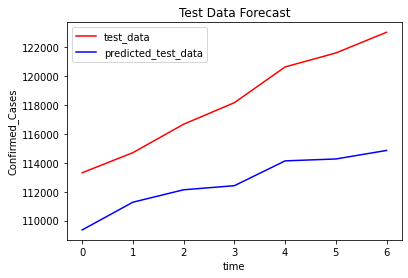

In [13]:
plt.plot(test, color= 'red', label = 'test_data')
plt.plot(test_predicted, color= 'blue', label = 'predicted_test_data')
plt.title('Test Data Forecast')
plt.xlabel('time')
plt.ylabel('Confirmed_Cases')
plt.legend()

In [14]:
x_input = test[-3:]
x_input = x_input.reshape((1, n_steps_in, n_features))
forecast = model.predict(x_input, verbose=0)

In [15]:
maximum_date = features.index.max()
date = pd.date_range(maximum_date, periods=8, closed='right')

Text(0, 0.5, 'Confirmed_Cases')

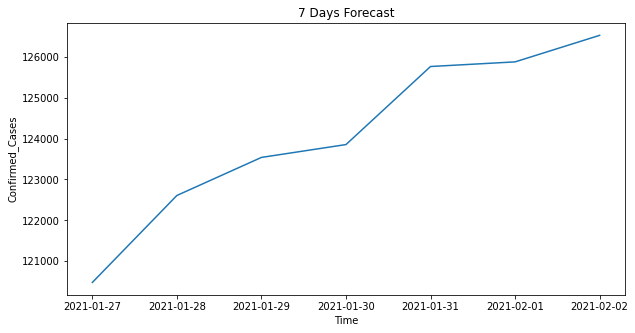

In [16]:
date = pd.Series(date)
forecast1 = forecast.reshape(n_steps_out,)
forecast2 = pd.Series(forecast1)
forcast_data = pd.concat([date,forecast2], axis=1)
forcast_data.columns = ['Date','Forecast_Corfirmed_Cases']
plt.figure(figsize=(10,5))
plt.plot(date,forecast2)
plt.title('7 Days Forecast')
plt.xlabel('Time')
plt.ylabel('Confirmed_Cases')

In [17]:
title = '## Daily New Covid Cases/Deaths in Nigeria' 
subtitle = 'This dashboard allows you see the date range of COVID-19 Cases in Nigeria.'

date_range_slider = pn.widgets.DateRangeSlider(
    name='Date Range Slider',
    start=datetime.datetime(2020, 3, 1), end=datetime.datetime(2021, 1, 1),
    value=(datetime.datetime(2020, 3, 1), datetime.datetime(2021, 1, 1))
)

In [18]:
@pn.depends(date_range_slider.param.value)
def get_plot_bar(date_range): # start function

    # daily cases per state
    df = nigeria_covid_cases.copy()
    
    start_date = date_range_slider.value[0] # store the first date range slider value in a var
    end_date = date_range_slider.value[1] # store the end date in a var
    mask = (df['Date_reported'] > start_date) & (df['Date_reported'] <= end_date) # create filter mask for the dataframe
    df = df.loc[mask] # filter the dataframe
    

    chart = alt.Chart(df).mark_bar().encode(x='Date_reported', y=alt.Y('New_cases', stack=None), opacity=alt.value(0.7))
    #chart = alt.layer(df).mark_bar(color="red").encode(x='Date_reported', y='New_deaths')
   
    return chart

dashboard = pn.Row(
    pn.Column(title, subtitle, date_range_slider),
    get_plot_bar # draw chart function!
)

dashboard.servable()

Row
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] DateRangeSlider(end=datetime.datetime(2021, ..., name='Date Range Slider', start=datetime.datetime(2020, ..., value=(datetime.datetime(2020, ..., value_end=datetime.datetime(2021, ..., value_start=datetime.datetime(2020, ...)
    [1] ParamFunction(function)

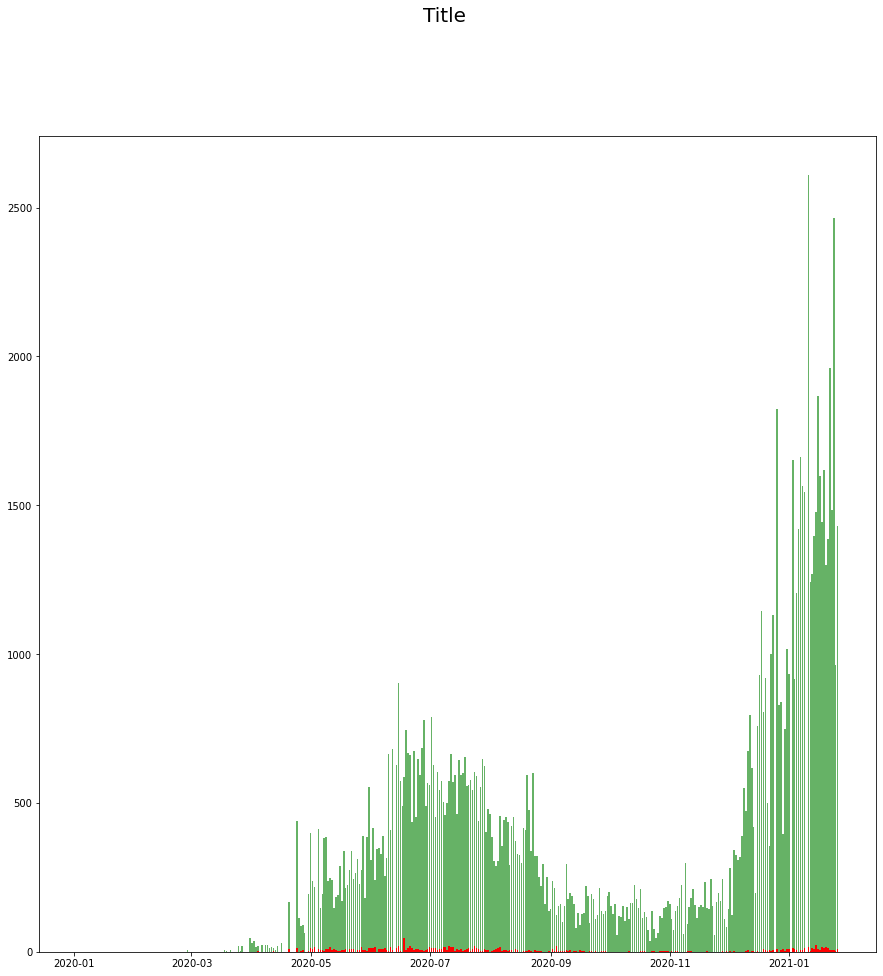

In [19]:
fig = plt.figure(figsize= (15,15))
plt.suptitle('Title',fontsize = 20,y=1.0)
plt.bar(nigeria_covid_cases['Date_reported'],nigeria_covid_cases['New_cases'],color = 'green',alpha = 0.6,label = 'New Cases')
plt.bar(nigeria_covid_cases['Date_reported'],nigeria_covid_cases['New_deaths'],color = 'red',label = 'New Deaths')
plt.show()

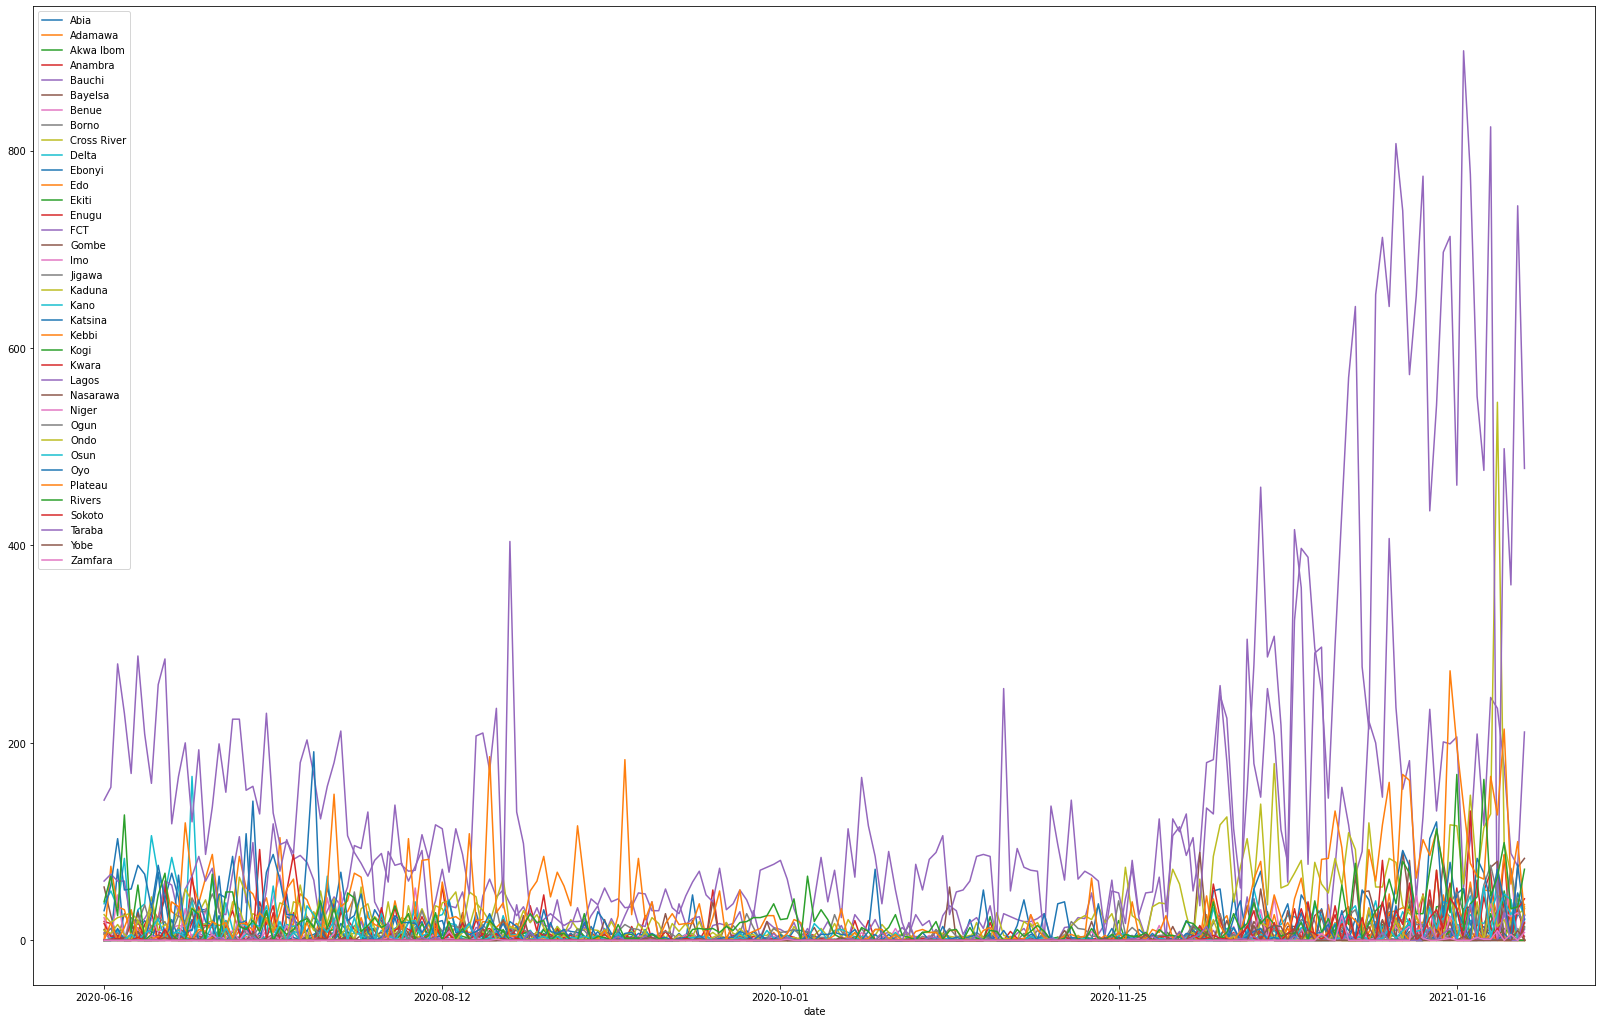

In [20]:
tweeted_cases = pd.read_csv('/content/drive/MyDrive/ncdc_twitter_daily.csv')
tweeted_cases_temp = tweeted_cases.set_index('date')
tweeted_cases_temp.plot(figsize=(28,18))



In [21]:
state_cases = tweeted_cases.melt(id_vars = 'date').rename(columns = {'variable':'state','value':'cases'})

In [22]:
title = '## Daily Covid Cases by States Total ' 
subtitle = 'This dashboard allows you to select a states in Nigeria and date range to see COVID-19 Cases.'


In [23]:
date_range_slider = pn.widgets.DateRangeSlider(
    name='Date Range Slider',
    start=datetime.datetime(2020, 3, 1), end=datetime.datetime(2021, 1, 1),
    value=(datetime.datetime(2020, 3, 1), datetime.datetime(2021, 1, 1))
)

In [24]:
@pn.depends(date_range_slider.param.value)
def get_plot_bar(date_range): # start function

    # daily cases per state
    df = state_cases
    
    df['date'] = pd.to_datetime(df['date'])
    
    
    start_date = date_range_slider.value[0] # store the first date range slider value in a var
    end_date = date_range_slider.value[1] # store the end date in a var
    mask = (df['date'] > start_date) & (df['date'] <= end_date) # create filter mask for the dataframe
    df = df.loc[mask] # filter the dataframe
    

    chart = alt.Chart(df).mark_bar().encode(x='date', y='sum(cases)', color='state', tooltip=['sum(cases)','state'])
    
    return chart

dashboard = pn.Row(
    pn.Column(title, subtitle, date_range_slider),
    get_plot_bar # draw chart function!
)

In [25]:
dashboard.servable()

Row
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] DateRangeSlider(end=datetime.datetime(2021, ..., name='Date Range Slider', start=datetime.datetime(2020, ..., value=(datetime.datetime(2020, ..., value_end=datetime.datetime(2021, ..., value_start=datetime.datetime(2020, ...)
    [1] ParamFunction(function)

In [26]:
title = '## Daily Covid Cases by States'

subtitle = 'This dashboard allows you to select a states in Nigeria and date range to see COVID-19 Cases.'

# create list of company names (tickers)
states_selection = tweeted_cases.columns[1:].tolist()

# this creates the dropdown widget
states_selection = pn.widgets.Select(name='State', options=states_selection)

# # this creates the date range slider
date_range_slider = pn.widgets.DateRangeSlider(
    name='Date Range Slider',
    start=datetime.datetime(2020, 3, 1), end=datetime.datetime(2021, 1, 1),
    value=(datetime.datetime(2020, 3, 1), datetime.datetime(2021, 1, 1))
)


In [27]:
@pn.depends(states_selection.param.value, date_range_slider.param.value)
def get_plot(states_selection, date_range): # start function

    # Load and format the data
    df = state_cases # define df
    df['date'] = pd.to_datetime(df['date']) 
    
    
    # create a date filter that uses values from the date range slider
    start_date = date_range_slider.value[0] # store the first date range slider value in a var
    end_date = date_range_slider.value[1] # store the end date in a var
    mask = (df['date'] > start_date) & (df['date'] <= end_date) # create filter mask for the dataframe
    df = df.loc[mask] # filter the dataframe
    
    # create the Altair chart object
    chart = alt.Chart(df).mark_area(color="#0c1944", opacity=0.8).encode(x='date', y='cases', tooltip=alt.Tooltip(['date','cases'])).transform_filter(
        (alt.datum.state == states_selection) # this ties in the filter from the dropdown selection
    )
    
    return chart

# create the Panel object, passing in all smaller objects

dashboard = pn.Row(
    pn.Column(title, subtitle, states_selection, date_range_slider),
    get_plot # draw chart function!
)

dashboard.servable()

Row
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Select(name='State', options=['Abia', 'Adamawa', ...], value='Abia')
        [3] DateRangeSlider(end=datetime.datetime(2021, ..., name='Date Range Slider', start=datetime.datetime(2020, ..., value=(datetime.datetime(2020, ..., value_end=datetime.datetime(2021, ..., value_start=datetime.datetime(2020, ...)
    [1] ParamFunction(function)